In [1]:
import math
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

In [2]:
def Make_Superpixel(h, w,img):
    return SuperPixels(h, w, img[h,w][0], img[h,w][1], img[h,w][2])

In [3]:
def initial_center(S, img, H, W, clusters):
    h = S // 2
    w = S // 2
    while h < H:
        while w < W:
            clusters.append(Make_Superpixel(h, w, img))
            w += S
        w = S // 2
        h += S
    return clusters

In [4]:
def get_gradient(h, w, img, H, W):
    if h + 1 >= H:
        h = H - 2
    if w + 1 >= W:
        w = W - 2
    
    grad = img[h+1,w+1][0] - img[h,w][0] + \
           img[h+1,w+1][1] - img[h,w][1] + \
           img[h+1,w+1][2] - img[h,w][2]
    return grad

In [5]:
def move_center(clusters, img, H, W):
    for c in clusters:
        grad = get_gradient(c.h, c.w, img, H, W)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                _h = c.h + dh
                _w = c.w + dw
                new_grad = get_gradient(_h, _w, img, H, W)
                if new_grad < grad:
                    c.update(_h, _w, img[_h,_w][0], img[_h,_w][1],img[_h,_w][2])
                    grad = new_grad


In [6]:
def assign_pixel(clusters, S, img, H, W, label, dist):
    for c in clusters:
        for h in range(c.h-2*S, c.h+2*S):
            if h < 0 or h >= H: continue
            for w in range(c.w-2*S, c.w+2*S):
                if w < 0 or w >= W: continue
                    
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l-c.l, 2) + math.pow(a-c.a, 2) + math.pow(b-c.b, 2))
                Ds = math.sqrt(math.pow(h-c.h, 2) + math.pow(w-c.w, 2))
                D = math.sqrt(math.pow(Dc/m, 2) + math.pow(Ds/S, 2))
                
                if D < dist[h,w]:
                    if (h,w) not in label:
                        label[(h,w)] = c
                        c.pixels.append((h,w))
                    else:
                        label[(h,w)].pixels.remove((h,w))
                        label[(h,w)] = c
                        c.pixels.append((h,w))
                    dist[h,w] = D

In [7]:
def update_center(clusters, img):
    for c in clusters:
        sum_h = sum_w = number = 0
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
        H = sum_h // number
        W = sum_w // number
        c.update(H, W, img[H,W][0], img[H,W][1], img[H,W][2])

In [8]:
# replace the pixels in the cluster by the center color
def avg_color(img, name, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        # set center to black
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    
    final_img = color.lab2rgb(image)
    plt.imshow(final_img)
    plt.imsave(name, final_img)

In [9]:
def slic(S, img, H, W, clusters, label, dist):
    clusters = initial_center(S, img, H, W, clusters)
    move_center(clusters, img, H, W)
    for i in range(10):
        assign_pixel(clusters,S,img,H,W,label,dist)
        update_center(clusters, img)
        if i == 9 :
            name = './slic/boy_m{m}_k{k}.png'.format(loop=i, m=m, k=k)
            avg_color(img, name, clusters)
                    
    return clusters

In [10]:
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

In [11]:
rgb = plt.imread("./img/boy.jpg")

img = color.rgb2lab(rgb)

k = 100   # number of clusters
m = 30    # normalizing the color proximity

H = img.shape[0]
W = img.shape[1]

N = H * W  # number of pixels
S = int(math.sqrt(N/k)) # average size of each superpixel

clusters = []
segments = np.full((H, W), -1)
label = {}
label2 = np.full((H, W), -1)
dist = np.full((H, W), np.inf)

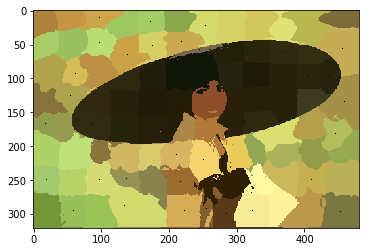

In [12]:
cluster = slic(S,img,H,W,clusters,label,dist)

In [13]:
index = 0
for c in clusters:
    li = np.array(list(c.pixels))
    n = np.array(li).shape[0]
    for i in range(n):
        xx = li[i,0]
        yy = li[i,1]
        label2[xx,yy] = index
    index += 1

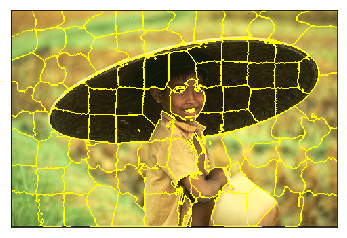

In [14]:
fig = plt.figure("Superpixels -- %d segments" % (k))
ax = fig.add_subplot(1, 1, 1)
boundary = ax.imshow(mark_boundaries(rgb, label2))

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig('./slic/boy_m{m}_k{k}_boundary.png'.format(loop=i, m=m, k=k), bbox_inches='tight',dpi=300,pad_inches=0.0)
